# Dropping a ball
Written by Tim Atherton for Computational Physics
    - Modified by: Kai Stewart, Felix Hu
January 16, 2020

This program aims to simulate the motion of a ball dropped from an initial height of $y0$ under gravity $g$ using the Euler discretization.

## Import libraries for plotting and numerical work

In [1]:
import sys
print(sys.version)

3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 15:01:53) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Set up general parameters for the calculation
- Gravitational acceleration constant: $10 \frac{m}{s^2}$

- Initial height: $y_0$ in $m$
- Initial velocity: $v_0$ in $\frac{m}{s}$
- Initial time: $t_0$ in $s$
- Time resolution: $dt$ in $0.1s$
- Total simulation time: $t_f$ in $s$

In [3]:
g = 10 ; y0 = 1.0 ; v0 = 0 ; t0 = 0 ; dt = 0.05 ; tf = 1.9 

## Set number of steps to take in the trajectory calculation

In [4]:
nsteps = int(tf/dt)+1
print("Number of calculation steps is: {}".format(nsteps))

Number of calculation steps is: 38


## Set the properties of the ball under investigations
- The properties $S_b$ of the individual balls is a collection of elements pertaining to the various physical properties of the ball in the test set.
- Property list:
    - Ball mass: $m$ in grams
    - Ball diameter: $d$ in mm
    - Ball radius: $r$ in mm
    - Ball surface area: $s_a = 4\pi r^2$ in mm$^2$ 
    - Ball material: $b_{mat}:$ $\{$'plastic':0, 'rubber':1, 'foam':2$\}$
    - Porosity: $p:$ $\{ 0.0, ..., 1.0 \}$
- Red Foam Ball
    - $S_r:$ $\{$ $m:$ 0.40,  $d:$ (29, 33), $r:$ (14.5, 16.5), $s_a:$ 3019.07, $b_{mat}:$, $p:$, $\}$
    - Note: The surface area of the red ball is computed using $r = \frac{1}{2}r_1r_2$
- Black Rubber Ball
    - $S_b:$ $\{$ $m:$ 24.55, $d:$ 39.8, $r:$ 19.9, $s_a:$ 4976.4, $b_{mat}:$, $p:$, $\}$
- White Plastic Ball
    - $S_w:$ $\{$ $m:$ 2.80, $d:$ 40.2, $r:$ 20.1, $s_a:$ 5076.94, $b_{mat}:$, $p:$, $\}$

In [5]:
Sr = {'color': 'Red',   'm': 0.40,  'd': 0.0, 'r': 15.5, 's_a': 3019.07, 'b_mat': None, 'p': 0.0, 'drag': 0.50}
Sb = {'color': 'Black', 'm': 24.55, 'd': 0.0, 'r': 19.9, 's_a': 4976.40, 'b_mat': None, 'p': 0.0, 'drag': 0.47}
Sw = {'color': 'White', 'm': 2.80,  'd': 0.0, 'r': 20.1, 's_a': 5076.94, 'b_mat': None, 'p': 0.0, 'drag': 0.47}

### Drag penalty equation
#### Function Contract: coefficient of drag, surface area of object, velocity of object, mass of object
- [Documentation](https://www.nuclear-power.net/nuclear-engineering/fluid-dynamics/what-is-drag-air-and-fluid-resistance/drag-force-drag-equation/)
- Units: m = grams, area = mm$^2$, velocity = m/s, coefficient = unitless
- Calculates the drag acceleration of an object with the given properties

In [6]:
def drag_accel(coefficient, area, flow_v, m):
    return (coefficient * (area * 0.000001) * ((1.225 * (flow_v**2))/2)) / (m * 0.001)

### Simulation quality determination function
- We propose the use of the Mean-Squared Error (MSE) as a quality metric for our simulation algorithm
- The MSE is used to assess the quality of a predictor function in its ability to estimate the outputs of another function. In this case, the simulation acts as our predictor function and the data provided by the tracker software represent the outputs we wish to map to.

#### Definition:

- $n$ is the number of point predictions in the simulation
- $X$ is a vector of observed values of the variable being predicted
- $\hat{X}$ is a vector of predictions
- The Mean-Squared Error of the prediction is:
    
$\text{MSE} = \frac{1}{n} \sum_{i=1}^n (X - \hat{X})^2 $

##### Function contract:
- predictions: a numpy array of values produced by the ball drop simulation algorithm
- targets: a numpy array of values produced by the tracker software

In [71]:
def MSE(predictions, targets):
    return np.square(np.subtract(predictions, targets)).mean()

## Computation of simulated trajectories using ball properties
- Note: We choose acceleration due to gravity to have a negative sign and penalize by adding drag in the positive direction

### Simulate Red Ball Trajectory

#### Load Red Ball Data from text file

In [103]:
red_ball = pd.read_csv('red_ball.txt', delimiter="\t")

In [104]:
red_t = red_ball['t']; red_x = red_ball['x']; red_y = red_ball['y']

#### Compute

In [105]:
t = np.linspace(t0,tf,nsteps); v = np.zeros([nsteps]); y = np.zeros([nsteps])
y[0] = red_y[0] # Set the simulation to same start position as tracker data
v[0] = v0

for i in range(1, nsteps):
    v[i] = v[i-1] + (dt * (-g + drag_accel(Sr['drag'], Sr['s_a'], v[i-1], Sr['m'])))
    y[i] = y[i-1] + v[i] * dt
    if y[i] < 0:
        break

In [106]:
y_r = y[y != 0.]    # ensure data is all non-zero

In [107]:
y_r = y_r.clip(min=0.) # ensure data does not contain negative values

In [108]:
t_r = t[0:len(y_r)] # match the array lengths for plotting

#### Bashford-Adams Algorithm

In [109]:
t1 = np.linspace(t0,tf,nsteps); v1 = np.zeros([nsteps]); y1 = np.zeros([nsteps])

In [110]:
y1[0] = red_y[0] # Set the simulation to same start position as tracker data
v1[1] = v1[0] + (dt * (-g + drag_accel(Sr['drag'], Sr['s_a'], v[i-1], Sr['m'])))
y1[1] = y1[0] + v1[0] * dt

for i in range(2, nsteps):
    v1[i] = v1[i-1] + (dt * (-g + drag_accel(Sr['drag'], Sr['s_a'], v1[i-1], Sr['m'])))
    y1[i] = y1[i-1] + ( (3/2) * dt * v1[i-1] ) - ( (1/2) * dt * v1[i-2] )
    if y[i] < 0:
        break

- Ensure that the position information does not contain negative values by truncating the array
- We match the length of the simulated data arays for plotting purposes

In [111]:
y1 = y1[y1 != 0.]

In [112]:
y1 = y1.clip(min=0.)

In [113]:
t1 = t1[0:len(y1)]

In [114]:
red_y = red_y.values[0: len(red_y.values) - 2]

In [115]:
red_t = red_t.values[0:len(red_y)]

#### Plot comparison between simulation and Tracker data

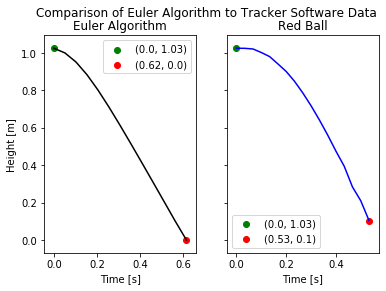

In [117]:
%matplotlib inline
fig, axes = plt.subplots(1,2, sharey=True)
plt.suptitle('Comparison of Euler Algorithm to Tracker Software Data')

# Simulation data
axes[0].plot(t_r, y_r, color='k')
axes[0].set_title("Euler Algorithm")
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Height [m]')

# Mark the start and end points of the simulated data
axes[0].scatter(0.0, y_r[0], label='({}, {})'.format(round(t_r[0], 2), round(y_r[0], 2) ), color='g')
axes[0].scatter(t_r[-1], y_r[-1], label='({}, {})'.format(round(t_r[-1], 2), round(y_r[-1], 2)), color='r')

# Tracker data
axes[1].plot(red_t, red_y, color='b')
axes[1].set_title('{} Ball'.format(Sr['color']))
axes[1].set_xlabel('Time [s]')

# Mark the start and end points of the Tracker generated data
label = '({}, {})'.format(round(red_t[0], 2), round(red_y[0], 2) )
axes[1].scatter(red_t[0], red_y[0], label=label, color='g')

label = '({}, {})'.format(round(red_t[-1], 2), round(red_y[-1], 2))
axes[1].scatter(red_t[-1], red_y[-1], label=label, color='r')

# Legends
axes[0].legend()
axes[1].legend()

plt.savefig('ball_drop_{}.png'.format(Sr['color']), dpi=300)

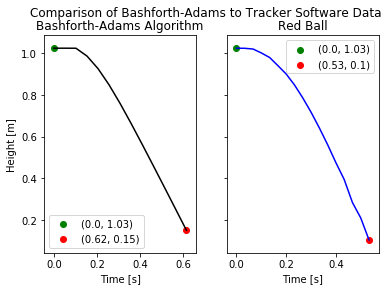

In [118]:
%matplotlib inline
fig, axes = plt.subplots(1,2, sharey=True)
plt.suptitle('Comparison of Bashforth-Adams to Tracker Software Data')

# Simulation data
axes[0].plot(t1, y1, color='k')
axes[0].set_title("Bashforth-Adams Algorithm")
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Height [m]')

# Mark the start and end points of the simulated data
axes[0].scatter(0.0, y1[0], label='({}, {})'.format(round(t1[0], 2), round(y1[0], 2) ), color='g')
axes[0].scatter(t1[-1], y1[-1], label='({}, {})'.format(round(t1[-1], 2), round(y1[-1], 2)), color='r')

# Tracker data
axes[1].plot(red_t, red_y, color='b')
axes[1].set_title('{} Ball'.format(Sr['color']))
axes[1].set_xlabel('Time [s]')

# Mark the start and end points of the Tracker generated data
label = '({}, {})'.format(round(red_t[0], 2), round(red_y[0], 2) )
axes[1].scatter(red_t[0], red_y[0], label=label, color='g')

label = '({}, {})'.format(round(red_t[-1], 2), round(red_y[-1], 2))
axes[1].scatter(red_t[-1], red_y[-1], label=label, color='r')

# Legends
axes[0].legend()
axes[1].legend()

plt.savefig('ball_drop_{}.png'.format(Sr['color']), dpi=300)

#### Get the MSE for the predictions vs targets

In [120]:
red_euler_MSE = MSE(y_r, red_y[0:len(y_r)])

In [121]:
print("The Mean-Squared Error for the {} ball using the Euler Algorithm is {}".format(Sr['color'], round(red_euler_MSE, 3)))

The Mean-Squared Error for the Red ball using the Euler Algorithm is 0.096


In [125]:
red_ba_MSE = MSE(y1, red_y[0:len(y1)] )

In [127]:
print("The Mean-Squared Error for the {} ball using the Euler Algorithm is {}".format(Sr['color'], round(red_ba_MSE, 3)))

The Mean-Squared Error for the Red ball using the Euler Algorithm is 0.036


### Simulate Black Ball Trajectory

#### Load Black Ball Data from text file

In [36]:
black_ball = pd.read_csv('black_ball.txt', delimiter="\t")

In [37]:
black_t = black_ball['t']; black_x = black_ball['x']; black_y = black_ball['y']

#### Compute

In [38]:
t = np.linspace(t0,tf,nsteps); v = np.zeros([nsteps]); y = np.zeros([nsteps])
y[0] = black_y[0] # Set the simulation to same start position as tracker data
v[0] = v0

for i in range(1, nsteps):
    v[i] = v[i-1] + (dt * (-g + drag_accel(Sb['drag'], Sb['s_a'], v[i-1], Sb['m'])))
    y[i] = y[i-1] + v[i] * dt
    if y[i] < 0:
        break

- Ensure that the position information does not contain negative values by truncating the array
- We match the length of the simulated data arays for plotting purposes

In [40]:
y_b = y[y != 0.] # ensure data is all non-zero

In [44]:
y_b = y_b.clip(min=0.) # ensure data does not contain negative values

In [46]:
t_b = t[0:len(y_b)] # match the array lengths for plotting

In [48]:
black_y = black_y.values[0: len(black_y.values)]

In [49]:
black_t = black_t.values[0:len(black_y)]

#### Plot comparison between simulation and Tracker data

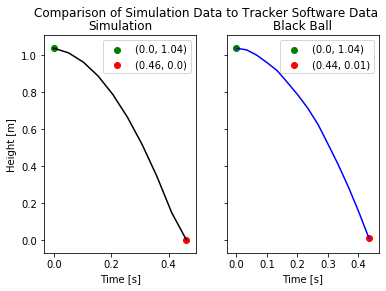

In [50]:
%matplotlib inline
fig, axes = plt.subplots(1,2, sharey=True)
plt.suptitle('Comparison of Simulation Data to Tracker Software Data')

# Simulation data
axes[0].plot(t_b, y_b, color='k')
axes[0].set_title("Simulation")
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Height [m]')

# Mark the start and end points of the simulated data
axes[0].scatter(0.0, y_b[0], label='({}, {})'.format(round(t_b[0], 2), round(y_b[0], 2) ), color='g')
axes[0].scatter(t_b[-1], y_b[-1], label='({}, {})'.format(round(t_b[-1], 2), round(y_b[-1], 2)), color='r')

# Tracker data
axes[1].plot(black_t, black_y, color='b')
axes[1].set_title('{} Ball'.format(Sb['color']))
axes[1].set_xlabel('Time [s]')

# Mark the start and end points of the Tracker generated data
label = '({}, {})'.format(round(black_t[0], 2), round(black_y[0], 2) )
axes[1].scatter(black_t[0], black_y[0], label=label, color='g')

label = '({}, {})'.format(round(black_t[-1], 2), round(black_y[-1], 2))
axes[1].scatter(black_t[-1], black_y[-1], label=label, color='r')

# Legends
axes[0].legend()
axes[1].legend()

plt.savefig('ball_drop_{}.png'.format(Sb['color']), dpi=300)

#### Get the MSE for the predictions vs targets

In [83]:
black_MSE = MSE(y_b, black_y[0:len(y_b)])

In [84]:
print("The Mean-Squared Error for the {} ball is {}".format(Sb['color'], round(black_MSE, 3)))

The Mean-Squared Error for the Black ball is 0.075


### Simulate White Ball Trajectory

#### Load White Ball Data from Text File

In [51]:
white_ball = pd.read_csv('white_ball.txt', delimiter="\t")

In [52]:
white_t = white_ball['t']; white_x = white_ball['x']; white_y = white_ball['y']

In [53]:
t = np.linspace(t0,tf,nsteps); v = np.zeros([nsteps]); y = np.zeros([nsteps])
y[0] = white_y[0] # Set the simulation to same start position as tracker data
v[0] = v0

for i in range(1, nsteps):
    v[i] = v[i-1] + (dt * (-g + drag_accel(Sw['drag'], Sw['s_a'], v[i-1], Sw['m'])))
    y[i] = y[i-1] + v[i] * dt
    if y[i] < 0:
        break

- Ensure that the position information does not contain negative values by truncating the array
- We match the length of the simulated data arays for plotting purposes

In [54]:
y_w = y[y != 0.]    # ensure data is all non-zero

In [55]:
y_w = y_w.clip(min=0.) # ensure data does not contain negative values

In [56]:
t_w = t[0:len(y_w)] # match the array lengths for plotting

In [57]:
white_y = white_y.values[0: len(white_y.values)]

In [58]:
white_t = white_t.values[0:len(white_y)]

#### Plot comparison between simulation and Tracker data

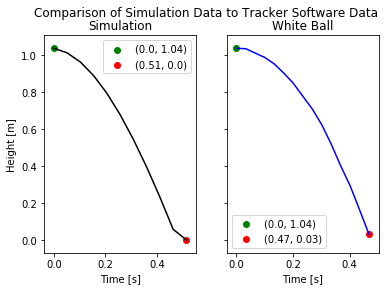

In [59]:
%matplotlib inline
fig, axes = plt.subplots(1,2, sharey=True)
plt.suptitle('Comparison of Simulation Data to Tracker Software Data')

# Simulation data
axes[0].plot(t_w, y_w, color='k')
axes[0].set_title("Simulation")
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Height [m]')

# Mark the start and end points of the simulated data
axes[0].scatter(0.0, y_w[0], label='({}, {})'.format(round(t_w[0], 2), round(y_w[0], 2) ), color='g')
axes[0].scatter(t_w[-1], y_w[-1], label='({}, {})'.format(round(t_w[-1], 2), round(y_w[-1], 2)), color='r')

# Tracker data
axes[1].plot(white_t, white_y, color='b')
axes[1].set_title('{} Ball'.format(Sw['color']))
axes[1].set_xlabel('Time [s]')

# Mark the start and end points of the Tracker generated data
label = '({}, {})'.format(round(white_t[0], 2), round(white_y[0], 2) )
axes[1].scatter(white_t[0], white_y[0], label=label, color='g')

label = '({}, {})'.format(round(white_t[-1], 2), round(white_y[-1], 2))
axes[1].scatter(white_t[-1], white_y[-1], label=label, color='r')

# Legends
axes[0].legend()
axes[1].legend()

plt.savefig('ball_drop_{}.png'.format(Sw['color']), dpi=300)

#### Get the MSE for the predictions vs targets

In [86]:
white_MSE = MSE(y_w, white_y[0:len(y_w)])

In [87]:
print("The Mean-Squared Error for the {} ball is {}".format(Sw['color'], round(white_MSE, 3)))

The Mean-Squared Error for the White ball is 0.104
